In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")
import pickle
from fuzzywuzzy import process

In [2]:
ratings=pd.read_csv('./data/ratings.csv',sep=',')
movies=pd.read_csv('./data/movies.csv',sep=',')

### Checking movies dataset

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [4]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [5]:
movies.shape

(9742, 3)

In [6]:
dup_movies=movies[movies.duplicated(subset=['title'])]['title'].tolist()
dup_movies

['Emma (1996)',
 'War of the Worlds (2005)',
 'Confessions of a Dangerous Mind (2002)',
 'Eros (2004)',
 'Saturn 3 (1980)']

In [7]:
# checking for duplicates
movies.duplicated(subset='title').value_counts()

False    9737
True        5
dtype: int64

In [8]:
# dropping duplicates 
movies.drop_duplicates(subset ="title", keep = 'first', inplace = True)
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


### Checking ratings dataset

In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [10]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [11]:
ratings.shape

(100836, 4)

In [12]:
ratings['movieId'].nunique()

9724

In [13]:
ratings['unique_id'] = ratings['movieId'] 
movies['unique_id'] = movies['movieId']

In [14]:
ratings['unique_id'].nunique(), movies['unique_id'].nunique()

(9724, 9737)

In [15]:
mov_rat=ratings.merge(movies, on=['unique_id'])

# check for number of unique ids
mov_rat['unique_id'].nunique()

9719

In [16]:
mov_rat

,userId,movieId_x,rating,timestamp,unique_id,movieId_y,title,genres
0,1,1,4.0,964982703,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,160341,160341,Bloodmoon (1997),Action|Thriller
100826,610,160527,4.5,1479544998,160527,160527,Sympathy for the Underdog (1971),Action|Crime|Drama
100827,610,160836,3.0,1493844794,160836,160836,Hazard (2005),Action|Drama|Thriller
100828,610,163937,3.5,1493848789,163937,163937,Blair Witch (2016),Horror|Thriller


In [17]:
unique_movies = mov_rat['title'].unique()
movies_dict = {unique_movies[i] : i for i in range(len(unique_movies))}
print(movies_dict)
print(len(movies_dict))

{'Toy Story (1995)': 0, 'Grumpier Old Men (1995)': 1, 'Heat (1995)': 2, 'Seven (a.k.a. Se7en) (1995)': 3, 'Usual Suspects, The (1995)': 4, 'From Dusk Till Dawn (1996)': 5, 'Bottle Rocket (1996)': 6, 'Braveheart (1995)': 7, 'Rob Roy (1995)': 8, 'Canadian Bacon (1995)': 9, 'Desperado (1995)': 10, 'Billy Madison (1995)': 11, 'Clerks (1994)': 12, 'Dumb & Dumber (Dumb and Dumber) (1994)': 13, 'Ed Wood (1994)': 14, 'Star Wars: Episode IV - A New Hope (1977)': 15, 'Pulp Fiction (1994)': 16, 'Stargate (1994)': 17, 'Tommy Boy (1995)': 18, 'Clear and Present Danger (1994)': 19, 'Forrest Gump (1994)': 20, 'Jungle Book, The (1994)': 21, 'Mask, The (1994)': 22, 'Blown Away (1994)': 23, 'Dazed and Confused (1993)': 24, 'Fugitive, The (1993)': 25, 'Jurassic Park (1993)': 26, 'Mrs. Doubtfire (1993)': 27, "Schindler's List (1993)": 28, 'So I Married an Axe Murderer (1993)': 29, 'Three Musketeers, The (1993)': 30, 'Tombstone (1993)': 31, 'Dances with Wolves (1990)': 32, 'Batman (1989)': 33, 'Silence of 

### Merging datasets

In [18]:
df = pd.merge(movies, ratings, on='movieId', how='right')
df

,movieId,title,genres,unique_id_x,userId,rating,timestamp,unique_id_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,1,4.0,964982703,1
1,3,Grumpier Old Men (1995),Comedy|Romance,3.0,1,4.0,964981247,3
2,6,Heat (1995),Action|Crime|Thriller,6.0,1,4.0,964982224,6
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,47.0,1,5.0,964983815,47
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,50.0,1,5.0,964982931,50
...,...,...,...,...,...,...,...,...
100831,166534,Split (2017),Drama|Horror|Thriller,166534.0,610,4.0,1493848402,166534
100832,168248,John Wick: Chapter Two (2017),Action|Crime|Thriller,168248.0,610,5.0,1493850091,168248
100833,168250,Get Out (2017),Horror,168250.0,610,5.0,1494273047,168250
100834,168252,Logan (2017),Action|Sci-Fi,168252.0,610,5.0,1493846352,168252


In [19]:
# check for number of movie ids
df['movieId'].nunique()

9724

In [20]:
# drop 
df['title'].isnull().values.any()

True

In [21]:
# checking the missing values
df['title'].isnull().sum()

6

In [22]:
df['genres']=df['genres'].astype(str)

In [23]:
# splitting 'genres' strings into lists
df['genres'] = df['genres'].apply(lambda x: x.split('|'))
df['genres']

0         [Adventure, Animation, Children, Comedy, Fantasy]
1                                         [Comedy, Romance]
2                                 [Action, Crime, Thriller]
3                                       [Mystery, Thriller]
4                                [Crime, Mystery, Thriller]
                                ...                        
100831                            [Drama, Horror, Thriller]
100832                            [Action, Crime, Thriller]
100833                                             [Horror]
100834                                     [Action, Sci-Fi]
100835                     [Action, Crime, Drama, Thriller]
Name: genres, Length: 100836, dtype: object

In [24]:
df.columns

Index(['movieId', 'title', 'genres', 'unique_id_x', 'userId', 'rating',
       'timestamp', 'unique_id_y'],
      dtype='object')

In [25]:
#import datetime
#df['timestamp']=df['timestamp'].astype(str)
#df['timestamp'] = pd.to_datetime(df['timestamp'])

In [26]:
df.drop(columns=['movieId', 'genres', 'timestamp','unique_id_x','unique_id_y'], inplace=True)
df

,title,userId,rating
0,Toy Story (1995),1,4.0
1,Grumpier Old Men (1995),1,4.0
2,Heat (1995),1,4.0
3,Seven (a.k.a. Se7en) (1995),1,5.0
4,"Usual Suspects, The (1995)",1,5.0
...,...,...,...
100831,Split (2017),610,4.0
100832,John Wick: Chapter Two (2017),610,5.0
100833,Get Out (2017),610,5.0
100834,Logan (2017),610,5.0


In [27]:
# save the df
#df.to_csv('3cols_df.csv')

In [28]:
ratings = df.pivot_table(index='userId',columns='title', values='rating')
ratings

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [29]:
ratings.mean().sort_values(ascending=False)

title
Tom Segura: Mostly Stories (2016)                                                    5.0
Winter in Prostokvashino (1984)                                                      5.0
The Adventures of Sherlock Holmes and Doctor Watson: The Treasures of Agra (1983)    5.0
The Adventures of Sherlock Holmes and Dr. Watson: Bloody Signature (1979)            5.0
When Worlds Collide (1951)                                                           5.0
                                                                                    ... 
Don't Look Now (1973)                                                                0.5
Journey 2: The Mysterious Island (2012)                                              0.5
Joe Dirt 2: Beautiful Loser (2015)                                                   0.5
Jesus Christ Vampire Hunter (2001)                                                   0.5
Fullmetal Alchemist 2018 (2017)                                                      0.5
Length: 9719, d

In [30]:
ratings.count(axis=1).sort_values(ascending=False)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Length: 610, dtype: int64

In [31]:
films = list(ratings.columns)

In [32]:
# cleaning the titles
def clean_title(df):
    cols = df.columns
    new_columns = []
    for col in cols:
        new = col.lstrip().rstrip().replace ("'", "")
        new_columns.append(new)  
        
    df.columns = new_columns

In [33]:
clean_title(ratings)
ratings

,71 (2014),Hellboy: The Seeds of Creation (2004),Round Midnight (1986),Salems Lot (2004),Til There Was You (1997),Tis the Season for Love (2015),"burbs, The (1989)",night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


### Missing values

In [34]:
# filling the missing data with mean value
def fill_nan(df):
    mean_values = df.mean().mean()
    df.fillna(mean_values,inplace=True)
    return df

In [35]:
ratings = fill_nan(ratings)
ratings

,71 (2014),Hellboy: The Seeds of Creation (2004),Round Midnight (1986),Salems Lot (2004),Til There Was You (1997),Tis the Season for Love (2015),"burbs, The (1989)",night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,...,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,4.000000,3.262378
2,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,...,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378
3,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,...,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378
4,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,...,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378
5,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,...,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,...,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378
607,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,...,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378
608,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,3.262378,...,3.262378,3.262378,3.262378,3.262378,3.262378,4.500000,3.500000,3.262378,3.262378,3.262378


### Create a movie-genre matrix

In [36]:
# instantiate NMF model
n_components=20
nmf_model = NMF(n_components=n_components)

In [37]:
nmf_model.fit(ratings)

NMF(n_components=20)

In [38]:
Q=nmf_model.components_

In [39]:
Q = pd.DataFrame(Q, columns=films, 
                 index=[f"feature_{i+1}" for i in range(n_components)])
Q.head(2)

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
feature_1,2.724674,0.512490,0.570660,0.602545,0.599074,0.360886,2.567757,0.495449,2.059434,0.431209,...,0.455572,0.088167,2.671457,0.545647,0.562496,2.108186,0.292125,0.058595,2.405734,0.585791
feature_2,49.437972,81.539645,83.558348,75.949182,76.714625,70.305254,93.771581,73.254754,148.500037,90.092202,...,96.204046,80.618073,48.970196,80.080503,85.554936,0.000000,66.391264,76.697953,150.270887,43.769321


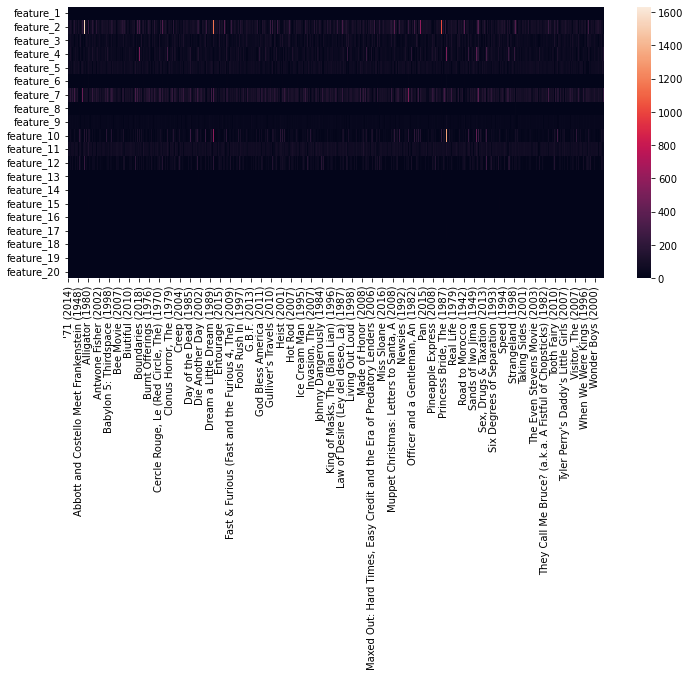

In [40]:
plt.figure(figsize=(12, 5))
sns.heatmap(Q, annot=False);

In [41]:
P = pd.DataFrame(nmf_model.transform(ratings),
                 index=ratings.index,
                 columns=[f"feature_{i+1}" for i in range(n_components)])

P.head(2)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
userId,,,,,,,,,,,,,,,,,,,,
1,0.188841,0.000444,0.003117,0.000015,0.004278,0.002578,0.000658,0.034624,0.001932,0.001147,0.001189,0.000514,0.090090,0.176184,0.044649,0.663177,0.228679,0.473629,0.0,0.001071
2,0.222863,0.000400,0.002223,0.000400,0.004080,0.008148,0.000377,0.039304,0.000709,0.000000,0.000492,0.000000,0.097955,0.183866,0.030459,0.610944,0.262614,0.542534,0.0,0.000000


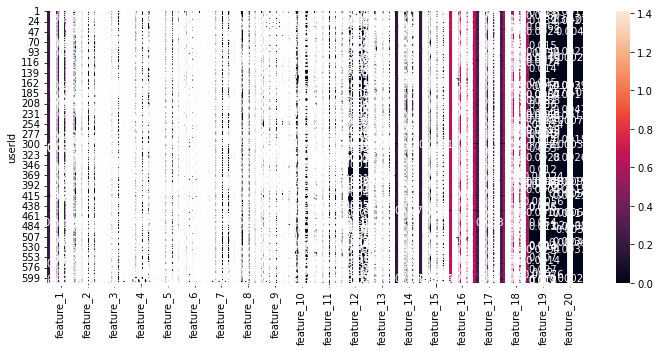

In [42]:
plt.figure(figsize=(12, 5))
sns.heatmap(P, annot=True);

In [43]:
R_hat = np.dot(P,Q).round(1)
R_hat=pd.DataFrame(R_hat, columns=ratings.columns, index=ratings.index)

R_hat.head(2)

,71 (2014),Hellboy: The Seeds of Creation (2004),Round Midnight (1986),Salems Lot (2004),Til There Was You (1997),Tis the Season for Love (2015),"burbs, The (1989)",night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.3,3.3,3.3,3.3,3.3,3.2,3.3,3.3,3.1,3.3,...,3.2,3.4,3.3,3.3,3.3,3.4,3.3,3.3,3.3,3.2
2,3.3,3.3,3.3,3.3,3.3,3.2,3.1,3.2,3.3,3.3,...,3.3,3.3,3.2,3.3,3.3,3.4,3.3,3.3,3.3,3.3


In [44]:
abs(ratings - R_hat)

,71 (2014),Hellboy: The Seeds of Creation (2004),Round Midnight (1986),Salems Lot (2004),Til There Was You (1997),Tis the Season for Love (2015),"burbs, The (1989)",night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.037622,0.037622,0.037622,0.037622,0.037622,0.062378,0.037622,0.037622,0.162378,0.037622,...,0.062378,0.137622,0.037622,0.037622,0.037622,0.137622,0.037622,0.037622,0.700000,0.062378
2,0.037622,0.037622,0.037622,0.037622,0.037622,0.062378,0.162378,0.062378,0.037622,0.037622,...,0.037622,0.037622,0.062378,0.037622,0.037622,0.137622,0.037622,0.037622,0.037622,0.037622
3,0.037622,0.037622,0.037622,0.037622,0.037622,0.062378,0.162378,0.062378,0.062378,0.037622,...,0.037622,0.037622,0.037622,0.037622,0.037622,0.137622,0.037622,0.037622,0.062378,0.037622
4,0.037622,0.037622,0.037622,0.037622,0.037622,0.062378,0.162378,0.062378,0.037622,0.037622,...,0.037622,0.037622,0.062378,0.037622,0.037622,0.037622,0.037622,0.037622,0.037622,0.037622
5,0.062378,0.037622,0.037622,0.037622,0.037622,0.062378,0.162378,0.062378,0.062378,0.037622,...,0.037622,0.037622,0.062378,0.037622,0.037622,0.137622,0.037622,0.037622,0.062378,0.037622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.037622,0.037622,0.062378,0.062378,0.062378,0.062378,0.362378,0.062378,0.337622,0.037622,...,0.062378,0.037622,0.037622,0.037622,0.062378,0.437622,0.037622,0.137622,0.062378,0.037622
607,0.037622,0.037622,0.037622,0.037622,0.037622,0.062378,0.062378,0.037622,0.062378,0.037622,...,0.037622,0.037622,0.062378,0.037622,0.037622,0.137622,0.037622,0.062378,0.062378,0.062378
608,0.062378,0.037622,0.037622,0.062378,0.062378,0.037622,0.662378,0.062378,0.037622,0.037622,...,0.037622,0.037622,0.062378,0.037622,0.037622,0.800000,0.200000,0.062378,0.262378,0.037622


In [45]:
nmf_model.reconstruction_err_

287.83805362812194

In [46]:
pickle.dump(nmf_model,open('nmf_model.sav', "wb"))

### Check2

In [54]:
with open('/Users/Varvara/spiced_working_files/pickle_dictionaries.p', "rb") as file1:
        dictionaries = pickle.load(file1)

In [55]:
movies_dict =dictionaries[0]
movie_title_dict = dictionaries[1]
top25 = dictionaries[2]

In [56]:
def user_rating():
    unique_movies = mov_rat['title'].unique()
    movies_dict = {unique_movies[i] : i for i in range(len(unique_movies))}
    movie_title_dict={key:value for (value,key) in enumerate(movies_dict)} 
    counter=0
    new_rating={}
    movies=[]
    
    for counter in range(6):
        movie=random.choice(movie_title_dict)
        if movie not in movies:
            fuzzy = process.extractOne(movie, movie_title_dict.keys())
            movies.append(movie) 
            input_data=input(f"Rate the {movie} from 0 to 5:")
            input_data.append(fuzzy[0])
            new_rating[movie]=input_data
            counter=+1
    return new_rating
        

In [57]:
def recommend_nmf(new_rating, model, k=10):
    """Filters and recommends the top k movies 
    for any given input query based 
    on a trained NMF model.

    Parameters
    ----------
    query : dict
        A dictionary of movies already seen. 
        Takes the form {"movie_A": 3, "movie_B": 3} etc
    nmf_model : pickle
        pickle nmf_model read from disk
    k : int, optional
        no. of top movies to recommend, by default 10
    """
    # construct a user vector
        
    unique_movies = mov_rat['title'].unique()
    movies_dict = {unique_movies[i] : i for i in range(len(unique_movies))}
    movie_title_dict={key:value for (value,key) in enumerate(movies_dict)} 
    
    n_rating=[np.nan] *len(movies_dict)
    
    for key, value in new_rating.items():
        index = movie_title_dict[key]
        n_rating[index] = value
        new_rating_list=np.array(n_rating).reshape(1,-1)


    user_dataframe = pd.DataFrame(new_rating_list, index=[
                                  'Recommendation'], columns=movies_dict).fillna(0)


    # 2. scoring

    # calculate the score with the NMF nmf_model
    model = pickle.load(open("nmf_model.sav", "rb"))
    # calculate the score with the NMF model
    user_P = model.transform(user_dataframe)
    Q = model.components_
    user_R = np.dot(user_P, Q)

    user_dataframe = pd.DataFrame(
        user_R, index=['Recommendation'], columns=ratings.columns)

    # 3. ranking

    # set zero score to movies already seen by the user
    unrated_boolean = np.isnan(new_query)[0]
    unrated_df = user_dataframe.iloc[:, unrated_boolean]
    sorted_new_user_df = unrated_df.T.sort_values(
        by='Recommendation', ascending=False).head(k)

    return sorted_new_user_df.head(k)

### Check nmf function

In [58]:
query = {'Silence of the Lambs, The (1991)': 5,
         'Fight Club (1999)': 5,
         'Toy Story (1995)': 4,
         'The Butterfly Effect (2004)': 4,
         'Ed Wood (1994)': 3,
         '(500) Days of Summer (2009)': 5,
         'Star Wars: Episode IV - A New Hope (1977)': 4,
         'Pulp Fiction (1994)': 5,
         'Space Jam (1996)': 4,
         'Stargate (1994)': 3,
         'Forrest Gump (1994)': 5,
         'Mask, The (1994)': 4,
         'Jurassic Park (1993)': 3,
         "Schindler's List (1993)": 5,
         'Batman (1989)': 4,
         }

In [59]:
def recommend_nmf(query, model, k=10):
    """Filters and recommends the top k movies 
    for any given input query based 
    on a trained NMF model.

    Parameters
    ----------
    query : dict
        A dictionary of movies already seen. 
        Takes the form {"movie_A": 3, "movie_B": 3} etc
    nmf_model : pickle
        pickle nmf_model read from disk
    k : int, optional
        no. of top movies to recommend, by default 10
    """
    # 1. candiate generation
    count = 0
    new_query = {}
    # construct a user vector
    for movie in ratings.columns:

        if movie not in query:
            # fuzzy = process.extractOne(movie, movie_title_dict.keys()) #matches the input
            new_query[movie] = np.nan
            # new_query.append(fuzzy[0])
        else:
            new_query[movie] = query[movie]

    new_query = pd.DataFrame(new_query, index=[0])
    new_query = np.array(new_query).reshape(1, -1)

    #print(new_query)

    user_dataframe = pd.DataFrame(new_query, index=[
                                  'Recommendation'], columns=ratings.columns).fillna(0)
    #print(user_dataframe)

    # 2. scoring

    # calculate the score with the NMF nmf_model
    model = pickle.load(open("nmf_model.sav", "rb"))
    # calculate the score with the NMF model
    user_P = model.transform(user_dataframe)
    Q = model.components_
    user_R = np.dot(user_P, Q)

    user_dataframe = pd.DataFrame(
        user_R, index=['Recommendation'], columns=ratings.columns)

    # 3. ranking

    # set zero score to movies already seen by the user
    unrated_boolean = np.isnan(new_query)[0]
    unrated_df = user_dataframe.iloc[:, unrated_boolean]
    sorted_new_user_df = unrated_df.T.sort_values(
        by='Recommendation', ascending=False).head(k)

    return sorted_new_user_df.head(k)

In [60]:
recommend_nmf(query,'nmf_model.sav',k=10)

,Recommendation
Star Wars: Episode V - The Empire Strikes Back (1980),0.509761
"Matrix, The (1999)",0.480403
Braveheart (1995),0.449613
Reservoir Dogs (1992),0.425721
Aliens (1986),0.424491
Terminator 2: Judgment Day (1991),0.420319
Saving Private Ryan (1998),0.419106
"Princess Bride, The (1987)",0.415396
"Usual Suspects, The (1995)",0.391554
"Godfather, The (1972)",0.379151


### Cosine similarity matrix

In [61]:
# transposing dataframe, users to columns, movies to index 
df_user_movie = df.pivot_table(values='rating', columns='userId', index='title')
df_user_movie

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,2.0
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5


In [ ]:
#filling nan with mean values
#df_user_movie=fill_nan(df_user_movie) 
#df_user_movie

In [62]:
#function to calcualte the cosine similarity between two vectors
def cosim(X, Y):
    num = np.nansum(X*Y) #np.dot(X, Y)
    denom = np.sqrt(np.nansum(X*X)*np.nansum(Y*Y)) # np.sqrt(np.dot(X, X)) * np.sqrt(np.dot(Y, Y))
    return num/denom

In [63]:
#converting column names to string
df_user_movie.columns=df_user_movie.columns.astype(str)

In [64]:
df_user_movie.index

Index([''71 (2014)', ''Hellboy': The Seeds of Creation (2004)',
       ''Round Midnight (1986)', ''Salem's Lot (2004)',
       ''Til There Was You (1997)', ''Tis the Season for Love (2015)',
       ''burbs, The (1989)', ''night Mother (1986)',
       '(500) Days of Summer (2009)', '*batteries not included (1987)',
       ...
       'Zulu (2013)', '[REC] (2007)', '[REC]² (2009)',
       '[REC]³ 3 Génesis (2012)',
       'anohana: The Flower We Saw That Day - The Movie (2013)',
       'eXistenZ (1999)', 'xXx (2002)', 'xXx: State of the Union (2005)',
       '¡Three Amigos! (1986)', 'À nous la liberté (Freedom for Us) (1931)'],
      dtype='object', name='title', length=9719)

In [65]:
df_user_movie

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,2.0
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5


In [66]:
# calculate the cosine similatity for 2 users
cosim(df_user_movie['7'], df_user_movie['20'])

0.17279973279091612

In [67]:
cosim_table = []
for user1 in df_user_movie.columns:
    row = []
    for user2 in df_user_movie.columns:
        row.append(cosim(df_user_movie[user1], df_user_movie[user2]))
    cosim_table.append(row)

In [68]:
df_cosim = pd.DataFrame(cosim_table, index=df_user_movie.columns, columns=df_user_movie.columns).round(2)

In [69]:
df_cosim

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.00,0.03,0.06,0.19,0.13,0.13,0.16,0.14,0.06,0.02,...,0.08,0.16,0.22,0.07,0.15,0.16,0.27,0.29,0.09,0.15
2,0.03,1.00,0.00,0.00,0.02,0.03,0.03,0.03,0.00,0.07,...,0.20,0.02,0.01,0.00,0.00,0.03,0.01,0.05,0.03,0.10
3,0.06,0.00,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.02,0.00,0.01,0.01,0.02,0.02,0.00,0.03
4,0.19,0.00,0.00,1.00,0.13,0.09,0.12,0.06,0.01,0.03,...,0.09,0.13,0.31,0.05,0.08,0.20,0.13,0.15,0.03,0.11
5,0.13,0.02,0.01,0.13,1.00,0.30,0.11,0.43,0.00,0.03,...,0.07,0.42,0.11,0.26,0.15,0.11,0.15,0.14,0.26,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.16,0.03,0.01,0.20,0.11,0.10,0.20,0.10,0.08,0.09,...,0.18,0.12,0.30,0.07,0.15,1.00,0.15,0.26,0.07,0.20
607,0.27,0.01,0.02,0.13,0.15,0.16,0.19,0.19,0.01,0.01,...,0.09,0.20,0.20,0.14,0.12,0.15,1.00,0.28,0.15,0.14
608,0.29,0.05,0.02,0.15,0.14,0.18,0.32,0.19,0.10,0.08,...,0.16,0.20,0.23,0.16,0.18,0.26,0.28,1.00,0.12,0.32


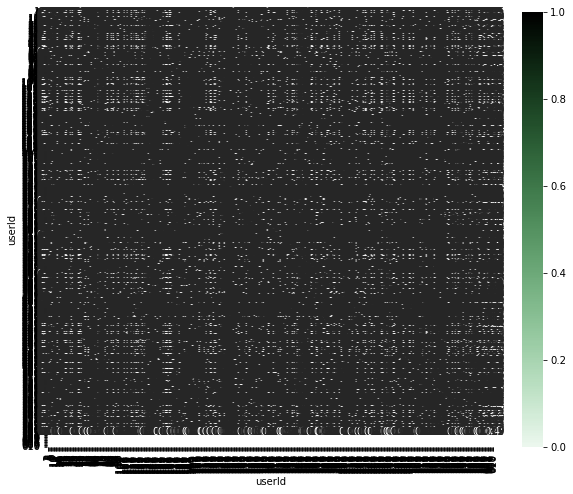

In [70]:
plt.figure(figsize=(10,8))
sns.heatmap(df_cosim[:-20], 
            annot=True, 
            linewidths=3, 
            cmap=sns.cubehelix_palette(start=2, 
                                       rot=0, 
                                       dark=.95, #0,
                                       light=0, #.95#
                                       reverse=True,
                                       as_cmap=True), 
            xticklabels=df_cosim.index, 
            yticklabels=df_cosim.index);

#### Predictions

In [76]:
# select a target user
new_user = pd.DataFrame(df_user_movie["7"])
new_user

,7
title,
'71 (2014),NaN
'Hellboy': The Seeds of Creation (2004),NaN
'Round Midnight (1986),NaN
'Salem's Lot (2004),NaN
'Til There Was You (1997),NaN
...,...
eXistenZ (1999),NaN
xXx (2002),NaN
xXx: State of the Union (2005),NaN


In [78]:
# select unseen movies
new_user = new_user.loc[new_user["7"].isnull()]
new_user

,7
title,
'71 (2014),NaN
'Hellboy': The Seeds of Creation (2004),NaN
'Round Midnight (1986),NaN
'Salem's Lot (2004),NaN
'Til There Was You (1997),NaN
...,...
eXistenZ (1999),NaN
xXx (2002),NaN
xXx: State of the Union (2005),NaN


In [79]:
other_users = df_user_movie.loc[df_user_movie["7"].isnull()]
other_users.fillna(value=0, inplace=True)
other_users

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0
xXx (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,2.0
xXx: State of the Union (2005),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5


In [80]:
cosim_user = pd.DataFrame(df_cosim["7"])
cosim_user

,7
userId,
1,0.16
2,0.03
3,0.00
4,0.12
5,0.11
...,...
606,0.20
607,0.19
608,0.32


In [81]:
# calculating numerator by multiplying the cosine similarity 
# with the ratings of other users for the unseen movies 
num = np.dot(other_users, cosim_user)
num

array([[ 0.76],
       [ 1.08],
       [ 1.19],
       ...,
       [ 2.39],
       [15.54],
       [ 0.12]])

In [82]:
# all cells will be 1 where where there is a rating
df_rating_count = other_users.where(other_users == 0, 1)
df_rating_count

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
xXx (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
xXx: State of the Union (2005),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [83]:
# calculating denominator by summing the weight of cosine similarity of users who have seen the movie
denom = np.dot(df_rating_count, cosim_user)
denom

array([[0.19],
       [0.27],
       [0.34],
       ...,
       [1.18],
       [4.94],
       [0.12]])

In [84]:
# calculating predicted ratings for the not seen movies of the picked user by dividing numerator and denominator
# sum_over_n(similarity*rating)/sum_over_n(similarity)
predicted_ratings = num/denom
predicted_ratings

df_predicted_ratings = pd.DataFrame(predicted_ratings, columns=["predicted_ratings"])
df_predicted_ratings

,predicted_ratings
0,4.000000
1,4.000000
2,3.500000
3,5.000000
4,3.500000
...,...
9562,3.867816
9563,2.836625
9564,2.025424
9565,3.145749


In [85]:
df_recommendation = pd.DataFrame(new_user.reset_index())

In [86]:
df_recommendation['predicted_ratings'] = df_predicted_ratings['predicted_ratings']
df_recommendation

,title,7,predicted_ratings
0,'71 (2014),NaN,4.000000
1,'Hellboy': The Seeds of Creation (2004),NaN,4.000000
2,'Round Midnight (1986),NaN,3.500000
3,'Salem's Lot (2004),NaN,5.000000
4,'Til There Was You (1997),NaN,3.500000
...,...,...,...
9562,eXistenZ (1999),NaN,3.867816
9563,xXx (2002),NaN,2.836625
9564,xXx: State of the Union (2005),NaN,2.025424
9565,¡Three Amigos! (1986),NaN,3.145749


In [95]:
# most recommended movies 
df_recommendation.sort_values(
    by='predicted_ratings', ascending=False).drop(columns="7").head(20)

,title,predicted_ratings
937,Belle époque (1992),5.0
408,"American Friend, The (Amerikanische Freund, De...",5.0
1675,Cheburashka (1971),5.0
7795,Spellbound (2011),5.0
1467,Buzzard (2015),5.0
5466,Meantime (1984),5.0
5708,More (1998),5.0
212,"Act of Killing, The (2012)",5.0
1216,Bobik Visiting Barbos (1977),5.0
8783,Trinity and Sartana Are Coming (1972),5.0


### Finding similar users

In [97]:
df_cosim

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.00,0.03,0.06,0.19,0.13,0.13,0.16,0.14,0.06,0.02,...,0.08,0.16,0.22,0.07,0.15,0.16,0.27,0.29,0.09,0.15
2,0.03,1.00,0.00,0.00,0.02,0.03,0.03,0.03,0.00,0.07,...,0.20,0.02,0.01,0.00,0.00,0.03,0.01,0.05,0.03,0.10
3,0.06,0.00,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.02,0.00,0.01,0.01,0.02,0.02,0.00,0.03
4,0.19,0.00,0.00,1.00,0.13,0.09,0.12,0.06,0.01,0.03,...,0.09,0.13,0.31,0.05,0.08,0.20,0.13,0.15,0.03,0.11
5,0.13,0.02,0.01,0.13,1.00,0.30,0.11,0.43,0.00,0.03,...,0.07,0.42,0.11,0.26,0.15,0.11,0.15,0.14,0.26,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.16,0.03,0.01,0.20,0.11,0.10,0.20,0.10,0.08,0.09,...,0.18,0.12,0.30,0.07,0.15,1.00,0.15,0.26,0.07,0.20
607,0.27,0.01,0.02,0.13,0.15,0.16,0.19,0.19,0.01,0.01,...,0.09,0.20,0.20,0.14,0.12,0.15,1.00,0.28,0.15,0.14
608,0.29,0.05,0.02,0.15,0.14,0.18,0.32,0.19,0.10,0.08,...,0.16,0.20,0.23,0.16,0.18,0.26,0.28,1.00,0.12,0.32


In [101]:
cosim_similar = pd.DataFrame(df_cosim["7"])
cosim_similar.drop(index="7", inplace=True)
cosim_similar = cosim_user.sort_values(by="7", ascending=False).head(10)
cosim_similar

,7
userId,
7,1.00
239,0.36
399,0.35
220,0.34
438,0.33
354,0.33
425,0.32
608,0.32
434,0.32


In [121]:
# creating a list of similar users for df_cosim["7"]
similar_user = list(cosim_similar.index)
similar_user

['7', '239', '399', '220', '438', '354', '425', '608', '434', '580']